# Работа с Excel

Материалы:
* Макрушин С.В. Лекция 7: Работа с Excel
* https://docs.xlwings.org/en/stable/quickstart.html
* https://nbviewer.jupyter.org/github/pybokeh/jupyter_notebooks/blob/master/xlwings/Excel_Formatting.ipynb#search_text


## Лабораторная работа 7.1

In [1]:
import pandas as pd

1. Загрузите данные из файлов `reviews_sample.csv` (__ЛР2__) и `recipes_sample.csv` (__ЛР5__) в виде `pd.DataFrame`. Обратите внимание на корректное считывание столбца(ов) с индексами. Оставьте в таблице с рецептами следующие столбцы: `id`, `name`, `minutes`, `submitted`, `description`, `n_ingredients`

In [2]:
reviews = pd.read_csv('reviews_sample.csv', index_col=0)
recipes = pd.read_csv('recipes_sample.csv', parse_dates=['submitted']).drop(['contributor_id', 'n_steps'], axis=1)

2. Случайным образом выберите 5% строк из каждой таблицы и сохраните две таблицы на разные листы в один файл `recipes.xlsx`. Дайте листам названия "Рецепты" и "Отзывы", соответствующие содержанию таблиц. 

In [3]:
reviews_5 = reviews.sample(frac=0.05)
recipes_5 = recipes.sample(frac=0.05)

with pd.ExcelWriter('recipes.xlsx') as writer:
    recipes_5.to_excel(writer, sheet_name='Рецепты')
    reviews_5.to_excel(writer, sheet_name='Отзывы')

3. Используя `xlwings`, добавьте на лист `Рецепты` столбец `seconds_assign`, показывающий время выполнения рецепта в секундах. Выполните задание при помощи присваивания массива значений диапазону ячеек.

In [4]:
import xlwings as xw

wb = xw.Book('recipes.xlsx')

sheet = wb.sheets['Рецепты']
sheet['H1'].value = 'seconds_assign'
rows = recipes_5.shape[0]
sheet.range('H2').options(index=False, header=False).value = recipes_5["minutes"] * 60

wb.save()

4. Используя `xlwings`, добавьте на лист `Рецепты` столбец `seconds_formula`, показывающий время выполнения рецепта в секундах. Выполните задание при помощи формул Excel.

In [5]:
wb = xw.Book('recipes.xlsx')

sheet = wb.sheets['Рецепты']

sheet['I1'].value = 'seconds_formula'
for row in range(2, rows+2):
    sheet[f'I{row}'].options(index=False).value = f'=D{row}*60'
    
wb.save()

5. Сделайте названия всех добавленных столбцов полужирными и выровняйте по центру ячейки.

In [6]:
wb = xw.Book('recipes.xlsx')

sheet = wb.sheets['Рецепты']

sheet['H1:I1'].font.bold = True
sheet.range('H1').api.HorizontalAlignment = xw.constants.HAlign.xlHAlignCenter
sheet.range('I1').api.HorizontalAlignment = xw.constants.HAlign.xlHAlignCenter

wb.save()

6. Раскрасьте ячейки столбца `minutes` в соответствии со следующим правилом: если рецепт выполняется быстрее 5 минут, то цвет - зеленый; от 5 до 10 минут - жёлтый; и больше 10 - красный.

In [7]:
wb = xw.Book('recipes.xlsx')

minutes = wb.sheets.active.range('D2').expand('down')

for cell in minutes:
    value = cell.value
    if value < 5:
        cell.color = (0, 255, 0) 
    elif 5 <= value <= 10:
        cell.color = (255, 255, 0)  
    else:
        cell.color = (255, 0, 0)

wb.save()

7. Добавьте на лист `Рецепты`  столбец `n_reviews`, содержащий кол-во отзывов для этого рецепта. Выполните задание при помощи формул Excel.

In [8]:
wb = xw.Book('recipes.xlsx')

reviews_sheet = wb.sheets['Отзывы']
recipes_sheet = wb.sheets['Рецепты']

recipes_sheet['J1'].value = 'n_reviews'
recipes_sheet['J1'].font.bold = True

recipes_ids = recipes_sheet.range('C2').expand('down')
for row in range(recipes_ids.shape[0]):
    count_reviews = reviews_sheet.range('C2').expand('down').value.count(recipes_ids[row].value)
    recipes_sheet[f'J{row+2}'].options(index=False).value = count_reviews
    
wb.save()

## Лабораторная работа 7.2

8. Напишите функцию `validate()`, которая проверяет соответствие всех строк из листа `Отзывы` следующим правилам:
    * Рейтинг - это число от 0 до 5 включительно
    * Соответствующий рецепт имеется на листе `Рецепты`
    
В случае несоответствия этим правилам, выделите строку красным цветом

In [9]:
def validate():
    wb = xw.Book('recipes.xlsx')
    
    reviews_sheet = wb.sheets['Отзывы']
    recipes_sheet = wb.sheets['Рецепты']
    
    rating_range = reviews_sheet.range('E2').expand('down')
    recipe_id_range = reviews_sheet.range('C2').expand('down')
    
    for i in range(1, rating_range.rows.count):
        rating = rating_range[i].value
        if rating < 0 or rating > 5:
            reviews_sheet.range(f"A{i+1}:F{i+1}").color = (255, 0, 0)
        
        recipe_id = recipe_id_range[i].value
        if not recipe_id_range[i].value in recipes_sheet.range('C2').expand('down').value:
            reviews_sheet.range(f"A{i+1}:F{i+1}").color = (255, 0, 0)
            
    wb.save()
            
    
validate()

9. В файле `recipes_model.csv` находится модель данных предметной области "рецепты". При помощи пакета `csv` считайте эти данные. При помощи пакета `xlwings` запишите данные на лист `Модель` книги `recipes_model.xlsx`, начиная с ячейки `A2`, не используя циклы. Сделайте скриншот текущего состояния листа и прикрепите в ячейку ноутбука. 

In [31]:
import csv

with open('recipes_model.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    rows = list(reader)

app = xw.App(visible=False)
wb = xw.Book()

sheet = wb.sheets.add('Модель')
sheet.range('A2').expand().value = rows

sheet1 = wb.sheets['Лист1']
sheet1.delete()

wb.save('recipes_model.xlsx')
app.quit()

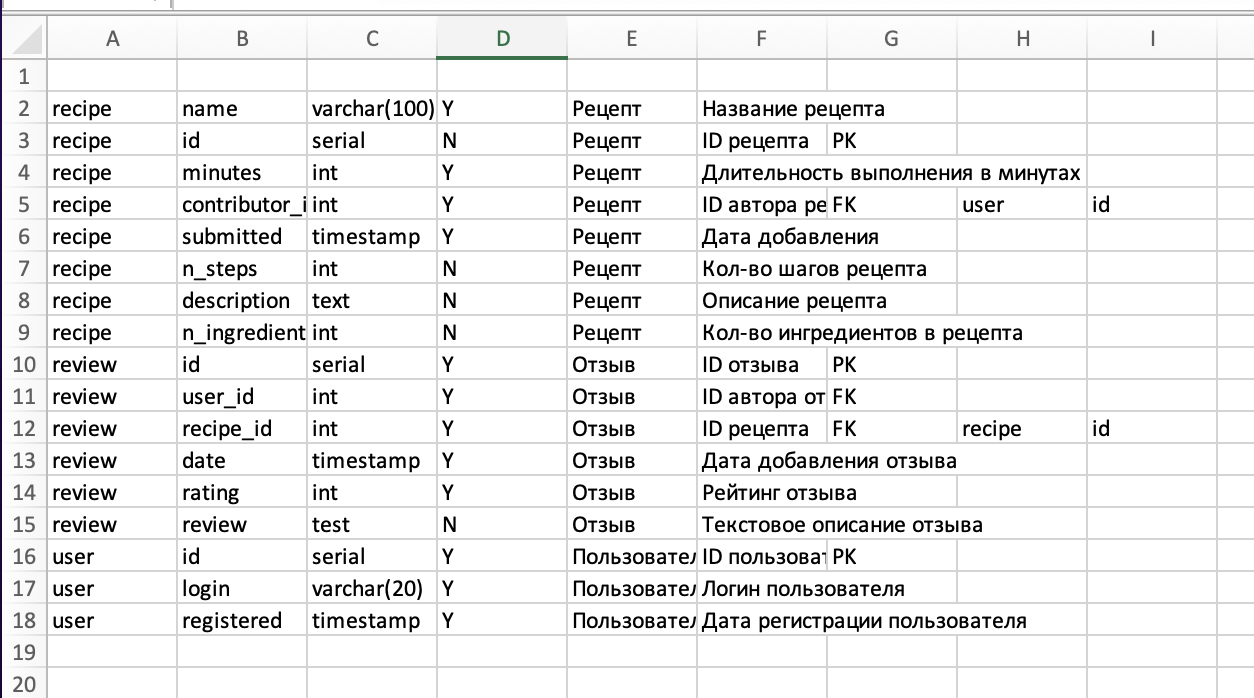

10. При помощи пакета `xlwings` добавьте в столбец J формулу для описания столбца на языке SQL. Формула должна реализовывать следующую логику:

    1\. в начале строки идут значения из столбцов В и C (значение столбца С приведено к верхнему регистру), разделенные пробелом
    
    2\. далее идут слова на основе столбца "Ключ"
        2.1 если в столбце "Ключ" указано значение "PK", то дальше через пробел идет ключевое слово "PRIMARY KEY"
        2.2 если в столбце "Ключ" указано значение "FK", то дальше через пробел идет ключевое слово "REFERENCES", затем значения столбцов H и I в формате "название_таблицы(название_столбца)"
        
    3\. если в столбце "Обязательно к заполнению" указано значение "Y" и в столбце "Ключ" указано не "PK", то дальше через пробел идет ключевое слово "NOT NULL".

Заполните этой формулой необходимое количество строк, используя "протягивание". Количество строк для протягивания определите на основе данных.

Сделайте скриншот текущего состояния листа и прикрепите в ячейку ноутбука.

In [32]:
wb = xw.Book('recipes_model.xlsx')

sheet = wb.sheets['Модель']
num_rows = sheet.range('B2').current_region.last_cell.row
for i in range(2, num_rows+1):
    val_b = sheet.range(f'B{i}').value
    val_c = sheet.range(f'C{i}').value.upper()
    val_h = sheet.range(f'H{i}').value
    val_i = sheet.range(f'I{i}').value
    val_key = sheet.range(f'K{i}').value

    if val_key == 'PK':
        formula = f'{val_b} {val_c} PRIMARY KEY'
    elif val_key == 'FK':
        formula = f'{val_b} {val_c} REFERENCES {val_h}({val_i})'
    elif val_key != 'PK' and sheet.range(f'J{i}').value == 'Y':
        formula = f'{val_b} {val_c} NOT NULL'
    else:
        formula = f'{val_b} {val_c}'
    
    sheet.range(f'J{i}').formula = formula

wb.save()

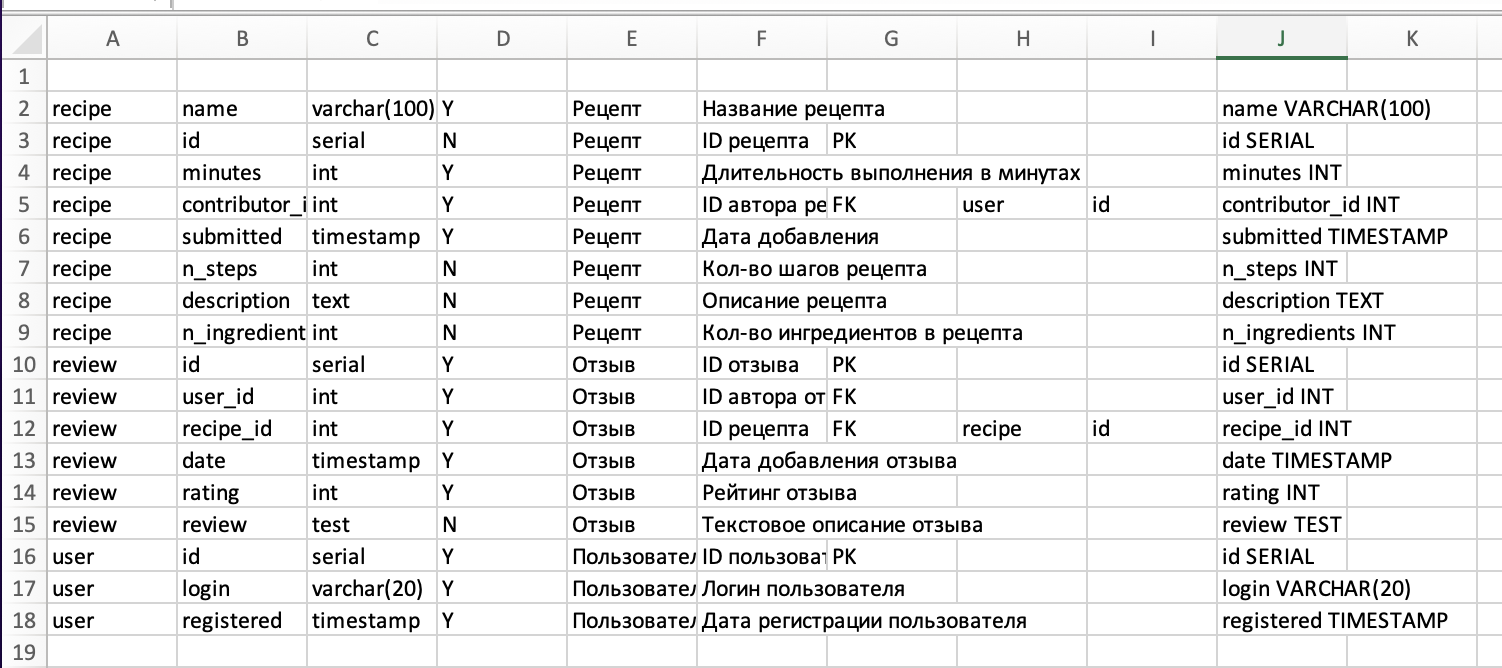

11. При помощи пакета `xlwings` измените стилизацию листа `Модель`.
* для заголовков добавьте заливку цвета `00ccff`
* примените автоподбор ширины столбца;
* сделайте шрифт заголовков полужирным;
* добавьте таблице автофильтр.

Сделайте скриншот текущего состояния листа и прикрепите в ячейку ноутбука.

In [33]:
wb = xw.Book('recipes_model.xlsx')

sheet = wb.sheets['Модель']

sheet.range('A1:J1').color = (0, 204, 255)
sheet.range('A1:J1').font.bold = True
sheet.autofit()
sheet.api.AutoFilterMode = True

wb.save()

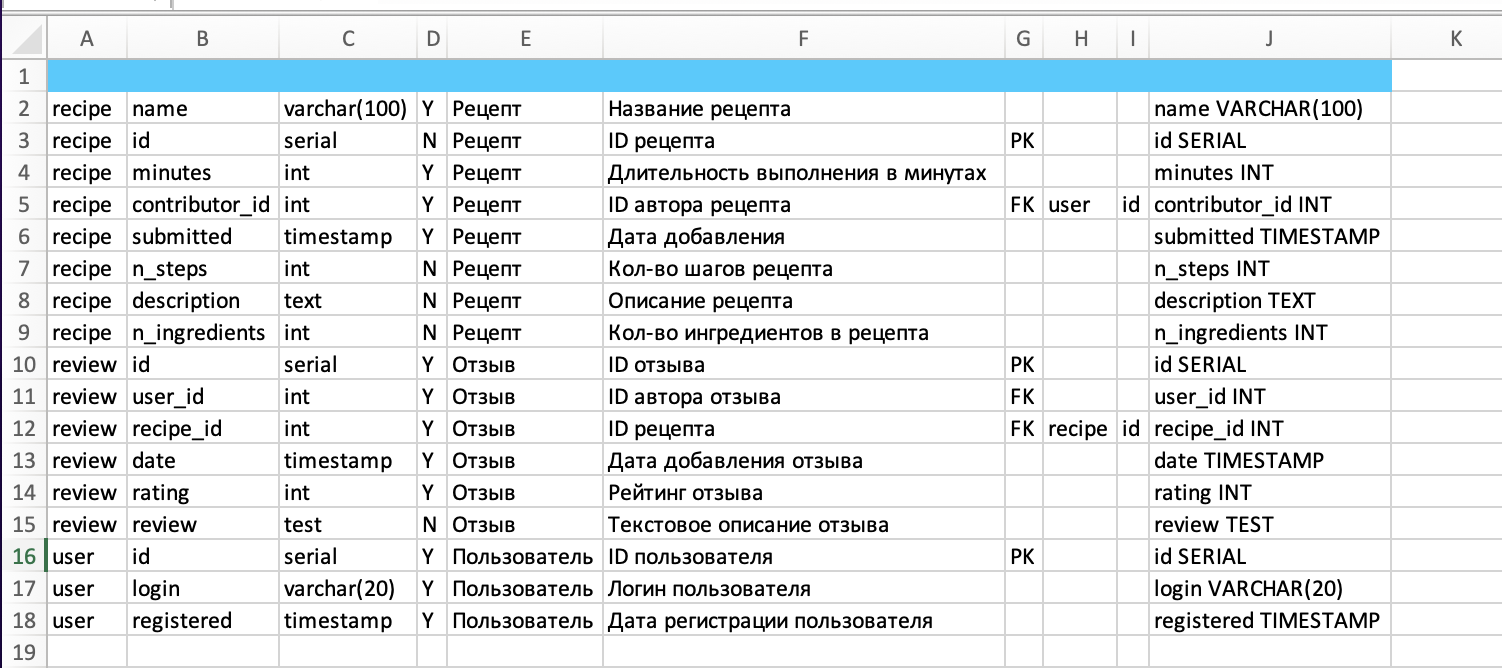

12. Посчитайте количество атрибутов для каждой из сущностей. Создайте лист `Статистика` и запишите в него результат группировки, начиная с ячейки "А1". Визуализируйте полученный результат при помощи столбчатой диаграммы. Сохраните полученную визуализацию на лист `Статистика`, начиная с ячейки "E2".  Сделайте скриншот листа `Статистика` и прикрепите в ячейку ноутбука.

* Вы можете воспользоваться методами для визуализации, которые поставляются вместе с объектами `pandas` (см. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot) 

In [42]:
wb = xw.Book('recipes_model.xlsx')

sheet = wb.sheets['Модель']

stats_sheet = wb.sheets.add(name='Статистика')

stats = sheet.range('A2').expand('down').options(transpose=True).value
stats = [s.split()[0] for s in stats if s]
stats_count = {s:stats.count(s) for s in set(stats)}

stats_sheet.range('A1').value = 'Сущность'
stats_sheet.range('B1').value = 'Количество атрибутов'
row_num = 2
for s, count in stats_count.items():
    stats_sheet.range(f'A{row_num}').value = s
    stats_sheet.range(f'B{row_num}').value = count
    row_num += 1

chart = stats_sheet.charts.add()
chart.set_source_data(stats_sheet.range('A1:B4'))
chart.chart_type = 'column_clustered'
chart.x_axis_title = 'Сущность'
chart.y_axis_title = 'Количество атрибутов'

chart.top = stats_sheet.range('E2').top
chart.left = stats_sheet.range('E2').left

wb.save()

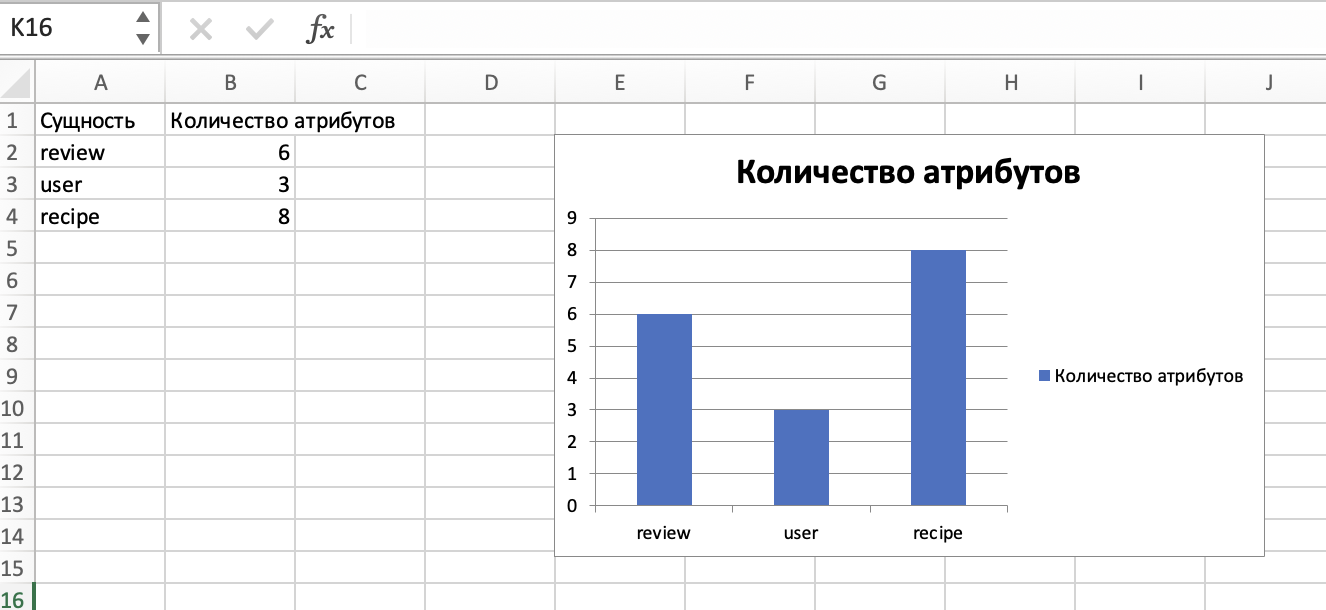